##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# SavedModel 포맷 사용하기

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://www.tensorflow.org/guide/saved_model">     <img src="https://www.tensorflow.org/images/tf_logo_32px.png">     TensorFlow.org에서 보기</a>   </td>
  <td>     <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ko/guide/saved_model.ipynb">     <img src="https://www.tensorflow.org/images/colab_logo_32px.png">     구글 코랩(Colab)에서 실행하기</a>   </td>
  <td>     <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ko/guide/saved_model.ipynb">     <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">     깃허브(GitHub) 소스 보기</a>   </td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ko/guide/saved_model.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">노트북 다운로드</a></td>
</table>

SavedModel에는 가중치 및 연산을 포함한 완전한 텐서플로 프로그램이 포함됩니다. 기존에 설계했던 모델 코드를 실행할 필요가 없어 공유하거나 ([TFLite](https://tensorflow.org/lite), [TensorFlow.js](https://js.tensorflow.org/), [TensorFlow Serving](https://www.tensorflow.org/tfx/serving/tutorials/Serving_REST_simple), [TFHub](https://tensorflow.org/hub)와 같은 환경으로) 배포하는 데 유용합니다.

파이썬 모델 코드를 가지고 있고 파이썬 내에서 가중치를 불러오고 싶다면, [체크포인트 훈련 가이드](./checkpoint.ipynb)를 참조하세요.

- 로우 레벨 `tf.saved_model` API. 이 문서는 API를 사용하는 방법을 자세히 설명합니다.
    - 저장: `tf.saved_model.save(model, path_to_dir)`
    - 로드: `model = tf.saved_model.load(path_to_dir)`
- 하이 레벨 `tf.keras.Model` API. [Keras 모델 저장 및 로드](https://www.tensorflow.org/guide/keras/save_and_serialize)를 참조하세요.
- 훈련을 진행하는 동안 가중치를 저장/로드하려면 [체크포인트 가이드](./checkpoint.ipynb)를 참조하세요.

주의: TensorFlow 모델은 코드이며 신뢰할 수 없는 코드에 주의하는 것이 중요합니다. 자세한 내용은 [TensorFlow 안전하게 사용하기](https://github.com/tensorflow/tensorflow/blob/master/SECURITY.md)를 참고하세요.


## Keras에서 SavedModel 생성하기

빠른 도입을 위해 이 섹션에서는 사전에 훈련한 Keras 모델을 내보내고 이와 함께 이미지 분류 요청을 제공합니다. 가이드의 나머지 부분에서는 세부 정보를 채우고 SavedModels를 생성하는 다른 방법에 대해 논의합니다.

In [2]:
import os
import tempfile

from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf

tmpdir = tempfile.mkdtemp()

2022-12-14 21:59:52.952795: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-14 21:59:52.952894: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-14 21:59:52.952905: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
  tf.config.experimental.set_memory_growth(device, True)

 8192/61306 [===>..........................] - ETA: 0s

61306/61306 [==============================] - 0s 0us/step


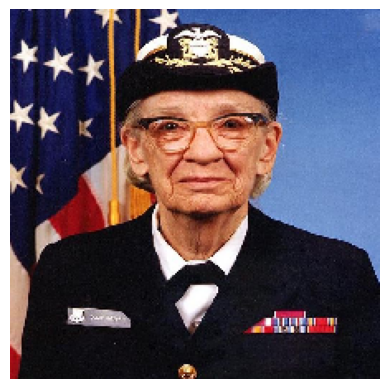

In [4]:
file = tf.keras.utils.get_file(
    "grace_hopper.jpg",
    "https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg")
img = tf.keras.utils.load_img(file, target_size=[224, 224])
plt.imshow(img)
plt.axis('off')
x = tf.keras.utils.img_to_array(img)
x = tf.keras.applications.mobilenet.preprocess_input(
    x[tf.newaxis,...])

실행 예제로 그레이스 호퍼(Grace Hopper)의 이미지와 사용이 쉬운 케라스 사전 훈련 이미지 분류 모델을 사용할 것입니다. 사용자 정의 모델도 사용할 수 있는데, 자세한 것은 나중에 설명합니다.

In [5]:
labels_path = tf.keras.utils.get_file(
    'ImageNetLabels.txt',
    'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

 8192/10484 [======================>.......] - ETA: 0s

10484/10484 [==============================] - 0s 0us/step


In [6]:
pretrained_model = tf.keras.applications.MobileNet()
result_before_save = pretrained_model(x)

decoded = imagenet_labels[np.argsort(result_before_save)[0,::-1][:5]+1]

print("Result before saving:\n", decoded)

    8192/17225924 [..............................] - ETA: 0s

 2834432/17225924 [===>..........................] - ETA: 0s

 9682944/17225924 [===============>..............] - ETA: 0s

16785408/17225924 [============================>.] - ETA: 0s

17225924/17225924 [==============================] - 0s 0us/step


Result before saving:
 ['military uniform' 'bow tie' 'suit' 'bearskin' 'pickelhaube']


이 이미지의 가장 가능성 있는 예측은 "군복"입니다.

In [7]:
mobilenet_save_path = os.path.join(tmpdir, "mobilenet/1/")
tf.saved_model.save(pretrained_model, mobilenet_save_path)

INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpkcm26pwl/mobilenet/1/assets


INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpkcm26pwl/mobilenet/1/assets


저장 경로의 마지막 경로 요소(여기서는 `1/`)는 모델의 버전 번호인 텐서플로 서빙(TensorFlow Serving) 컨벤션을 따릅니다 - 텐서플로 서빙과 같은 도구가 최신 모델을 구분할 수 있게 합니다.

SavedModel은 시그니처(signatures)라 불리는 이름있는 함수를 가집니다. 케라스 모델은 `serving_default` 시그니처 키를 사용하여 정방향 패스(forward pass)를 내보냅니다. [SavedModel 커맨드 라인 인터페이스](#details_of_the_savedmodel_command_line_interface)는 디스크에 저장된 SavedModel을 검사할 때 유용합니다.

In [8]:
loaded = tf.saved_model.load(mobilenet_save_path)
print(list(loaded.signatures.keys()))  # ["serving_default"]

['serving_default']


가져온 시그니처는 항상 딕셔너리를 반환합니다.

In [9]:
infer = loaded.signatures["serving_default"]
print(infer.structured_outputs)

{'predictions': TensorSpec(shape=(None, 1000), dtype=tf.float32, name='predictions')}


SavedModel로부터 추론을 실행하면 처음 모델과 같은 결과를 제공합니다.

In [10]:
labeling = infer(tf.constant(x))[pretrained_model.output_names[0]]

decoded = imagenet_labels[np.argsort(labeling)[0,::-1][:5]+1]

print("Result after saving and loading:\n", decoded)

Result after saving and loading:
 ['military uniform' 'bow tie' 'suit' 'bearskin' 'pickelhaube']


## 텐서플로 서빙으로 모델 배포하기

SavedModel은 파이썬에서 사용하기에 적합하지만, 일반적으로 프로덕션 환경에서는 추론을 위한 전용 서비스를 사용합니다. 이는 텐서플로 서빙을 사용한 SavedModel로 쉽게 구성할 수 있습니다.

`tensorflow_model_server`를 노트북이나 로컬 머신에 설치하는 방법을 포함한 텐서플로 서빙에 대한 자세한 내용은 [TensorFlow Serving REST 튜토리얼](https://github.com/tensorflow/serving/blob/master/tensorflow_serving/g3doc/tutorials/Serving_REST_simple.ipynb)을 참조하십시오. 간단한 예를 들면 앞서 내보낸 `mobilenet` 모델을 배포하기 위해 모델 경로를 SavedModel 디렉토리로 설정합니다:

## 디스크에 SavedModel 형식

SavedModel은 변수값과 상수를 포함하고 직렬화된 시그니처와 이를 실행하는 데 필요한 상태를 담은 디렉토리입니다.


In [11]:
!ls {mobilenet_save_path}

assets	fingerprint.pb	saved_model.pb	variables


`saved_model.pb` 파일은 각각 하나의 함수로 된 이름있는 시그니처 세트를 포함합니다.

SavedModel에는 다중 시그니처 세트(`saved_model_cli`의 `tag_set` 매개변수 값으로 확인된 다중 MetaGraph)를 포함할 수 있지만 이런 경우는 드뭅니다. 다중 시그니처 세트를 작성하는 API에는 [`tf.Estimator.experimental_export_all_saved_models`](https://www.tensorflow.org/api_docs/python/tf/estimator/Estimator#experimental_export_all_saved_models) 및 TensorFlow 1.x의 `tf.saved_model.Builder`가 포함됩니다.

In [12]:
!saved_model_cli show --dir {mobilenet_save_path} --tag_set serve

2022-12-14 22:00:11.410121: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-14 22:00:11.410219: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-14 22:00:11.410230: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


The given SavedModel MetaGraphDef contains SignatureDefs with the following keys:
SignatureDef key: "__saved_model_init_op"
SignatureDef key: "serving_default"


`variables` 디렉토리에는 일반적인 훈련 체크포인트 파일이 있습니다([훈련 체크포인트 가이드](./checkpoint.ipynb) 참조).

In [13]:
!ls {mobilenet_save_path}/variables

variables.data-00000-of-00001  variables.index


`assets` 디렉토리에는 텐서플로 그래프(TensorFlow graph)에서 사용되는 파일들, 예를 들어 상수 테이블을 초기화하는 데 사용되는 텍스트 파일들이 있습니다. 이번 예제에서는 사용되지 않습니다.

SavedModel은 텐서플로 그래프에서 사용되지 않는 파일을 위해 `assets.extra` 디렉토리를 가질 수 있는데, 예를 들면 사용자가 SavedModel과 함께 사용할 파일입니다. 텐서플로 자체는 이 디렉토리를 사용하지 않습니다.

## 사용자 정의 모델 저장하기

`tf.saved_model.save`는 `tf.keras.Layer` 및 `tf.keras.Model`과 같은 `tf.Module` 개체 및 해당 서브 클래스의 저장을 지원합니다.

`tf.Module`을 저장하고 복원하는 예제를 살펴보겠습니다.


In [14]:
class CustomModule(tf.Module):

  def __init__(self):
    super(CustomModule, self).__init__()
    self.v = tf.Variable(1.)

  @tf.function
  def __call__(self, x):
    print('Tracing with', x)
    return x * self.v

  @tf.function(input_signature=[tf.TensorSpec([], tf.float32)])
  def mutate(self, new_v):
    self.v.assign(new_v)

module = CustomModule()

`tf.Module`을 저장하면 재귀 순회를 통해 찾은 모든 `tf.Variable` 속성, `tf.function` 데코레이트 메서드, `tf.Module`이 저장됩니다(이 재귀 순회에 대한 자세한 내용은 [체크포인트 튜토리얼](./checkpoint.ipynb)을 참조하세요). 다만 모든 Python 속성, 함수 및 데이터는 손실됩니다. 이는 `tf.function`이 저장될 때 Python 코드는 저장되지 않음을 의미합니다.

Python 코드가 저장되지 않는다면 SavedModel은 함수를 복원하는 방법을 어떻게 알 수 있을까요?

간단히 말하자면 `tf.function`은 Python 코드를 추적하여 ConcreteFunction(`tf.Graph` 주변의 호출 가능한 래퍼(wrapper))을 생성하는 방식으로 작동합니다. `tf.function`을 저장하면 실제로는 `tf.function`의 ConcreteFunctions 캐시가 저장됩니다.

`tf.function`과 ConcreteFunctions의 관계에 대한 자세한 내용은 [tf.function 가이드](function.ipynb)를 참조하세요.

In [15]:
module_no_signatures_path = os.path.join(tmpdir, 'module_no_signatures')
module(tf.constant(0.))
print('Saving model...')
tf.saved_model.save(module, module_no_signatures_path)

Tracing with Tensor("x:0", shape=(), dtype=float32)
Saving model...
Tracing with Tensor("x:0", shape=(), dtype=float32)


INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpkcm26pwl/module_no_signatures/assets


INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpkcm26pwl/module_no_signatures/assets


## 사용자 정의 모델 로드하고 사용하기

Python에서 SavedModel을 로드하면 모든 `tf.Variable` 속성, `tf.function` 데코레이트 메서드 및 `tf.Module`이 원래 저장된 `tf.Module`과 동일한 개체 구조로 복원됩니다.

In [16]:
imported = tf.saved_model.load(module_no_signatures_path)
assert imported(tf.constant(3.)).numpy() == 3
imported.mutate(tf.constant(2.))
assert imported(tf.constant(3.)).numpy() == 6

Python는 저장되지 않으므로 새로운 입력 서명으로 `tf.function`을 호출하면 다음과 같이 실패하게 됩니다.

```python
imported(tf.constant([3.]))
```

<pre>ValueError: Could not find matching function to call for canonicalized inputs ((&lt;tf.Tensor 'args_0:0' shape=(1,) dtype=float32&gt;,), {}). Only existing signatures are [((TensorSpec(shape=(), dtype=tf.float32, name=u'x'),), {})].
</pre>

### 기본 미세 조정

변수 개체를 사용할 수 있으며 가져온 함수를 통해 역전파할 수 있습니다. 간단한 경우에 SavedModel을 미세 조정(즉, 재훈련)하기에는 이것으로 충분합니다.

In [17]:
optimizer = tf.keras.optimizers.SGD(0.05)

def train_step():
  with tf.GradientTape() as tape:
    loss = (10. - imported(tf.constant(2.))) ** 2
  variables = tape.watched_variables()
  grads = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(grads, variables))
  return loss

In [18]:
for _ in range(10):
  # "v" approaches 5, "loss" approaches 0
  print("loss={:.2f} v={:.2f}".format(train_step(), imported.v.numpy()))

loss=36.00 v=3.20
loss=12.96 v=3.92
loss=4.67 v=4.35
loss=1.68 v=4.61
loss=0.60 v=4.77
loss=0.22 v=4.86
loss=0.08 v=4.92
loss=0.03 v=4.95
loss=0.01 v=4.97
loss=0.00 v=4.98


### 일반 미세 조정

Keras의 SavedModel은 일반 `__call__`보다 [더 많은 세부정보](https://github.com/tensorflow/community/blob/master/rfcs/20190509-keras-saved-model.md#serialization-details)를 제공하여 고급 미세 조정 사례를 다룹니다. TensorFlow Hub는 해당되는 경우 미세 조정을 위해 공유된 SavedModels에서 다음을 제공하는 것이 좋습니다.

- 모델링 드롭아웃 또는 순방향 전달이 훈련과 추론 사이에 다른 기술(예: 배치 정규화)을 사용하는 경우, `__call__` 메서드는 선택적으로 기본값이 `False`이지만 `True`로 설정할 수 있는 Python 값 `training=` 인수를 선택합니다.
- `__call__` 속성 옆에는 해당 변수 목록과 함께 `.variable` 및 `.trainable_variable` 속성이 있습니다. 원래는 훈련할 수 있었지만 미세 조정 중에 고정되도록 의도된 변수가 `.trainable_variables`에서 생략됩니다.
- 가중치 정규화기를 레이어 또는 하위 모델의 속성으로 나타내는 Keras와 같은 프레임워크를 위해 `.regularization_losses` 속성도 있을 수 있습니다. 이것은 총 손실에 추가하기 위한 값을 갖는 인수가 없는(zero-argument) 함수 목록을 보유합니다.

초기의 MobileNet 예제로 돌아가면 다음 중 일부가 작동하는 것을 볼 수 있습니다.

In [19]:
loaded = tf.saved_model.load(mobilenet_save_path)
print("MobileNet has {} trainable variables: {}, ...".format(
          len(loaded.trainable_variables),
          ", ".join([v.name for v in loaded.trainable_variables[:5]])))

MobileNet has 83 trainable variables: conv1/kernel:0, conv1_bn/gamma:0, conv1_bn/beta:0, conv_dw_1/depthwise_kernel:0, conv_dw_1_bn/gamma:0, ...


In [20]:
trainable_variable_ids = {id(v) for v in loaded.trainable_variables}
non_trainable_variables = [v for v in loaded.variables
                           if id(v) not in trainable_variable_ids]
print("MobileNet also has {} non-trainable variables: {}, ...".format(
          len(non_trainable_variables),
          ", ".join([v.name for v in non_trainable_variables[:3]])))

MobileNet also has 54 non-trainable variables: conv1_bn/moving_mean:0, conv1_bn/moving_variance:0, conv_dw_1_bn/moving_mean:0, ...


## 내보내기 중에 서명 지정하기

TensorFlow Serving과 `saved_model_cli`와 같은 도구는 SavedModels과 상호작용할 수 있습니다. 이러한 도구가 사용할 ConcreteFunctions을 결정하는 데 도움이 되도록 적용 서명(serving signatures)을 지정해야 합니다. `tf.keras.Model`은 적용 서명을 자동으로 지정하지만 사용자는 당사의 사용자 정의 모듈에 대한 적용 서명을 명시적으로 선언해야 합니다.

중요: Python을 사용하여 TensorFlow 2.x 이외의 환경으로 모델을 내보내야 하는 경우가 아니면 명시적으로 서명을 내보낼 필요가 없을 것입니다. 특정 함수에 입력 서명을 강제 적용하는 방법을 찾고 있다면 `tf.function`에 대한 [`input_signature`](https://www.tensorflow.org/api_docs/python/tf/function#args_1) 인수를 참조하세요.

기본적으로 사용자 정의 `tf.Module`에는 서명이 선언되어 있지 않습니다.

In [21]:
assert len(imported.signatures) == 0

어떤 함수가 시그니처라는 것을 나타내려면 저장할 때 `signatures` 매개변수를 지정합니다.

In [22]:
module_with_signature_path = os.path.join(tmpdir, 'module_with_signature')
call = module.__call__.get_concrete_function(tf.TensorSpec(None, tf.float32))
tf.saved_model.save(module, module_with_signature_path, signatures=call)

Tracing with Tensor("x:0", dtype=float32)
Tracing with Tensor("x:0", dtype=float32)
INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpkcm26pwl/module_with_signature/assets


INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpkcm26pwl/module_with_signature/assets


In [23]:
imported_with_signatures = tf.saved_model.load(module_with_signature_path)
list(imported_with_signatures.signatures.keys())


['serving_default']

하나의 시그니처를 내보냈고 키는 기본값인 "serving_default"가 됩니다. 여러 시그니처를 내보내려면 딕셔너리로 전달합니다.

In [24]:
module_multiple_signatures_path = os.path.join(tmpdir, 'module_with_multiple_signatures')
signatures = {"serving_default": call,
              "array_input": module.__call__.get_concrete_function(tf.TensorSpec([None], tf.float32))}

tf.saved_model.save(module, module_multiple_signatures_path, signatures=signatures)

INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpkcm26pwl/module_with_multiple_signatures/assets


INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpkcm26pwl/module_with_multiple_signatures/assets


In [25]:
imported_with_multiple_signatures = tf.saved_model.load(module_multiple_signatures_path)
list(imported_with_multiple_signatures.signatures.keys())

['serving_default', 'array_input']

기본적으로 출력 텐서 이름은 `output_0`과 같이 상당히 일반적입니다. 출력 이름을 제어하려면 `tf.function`을 수정하여 출력 이름을 출력에 매핑하는 사전을 반환합니다. 입력 이름은 Python 함수 arg 이름에서 파생됩니다.

In [26]:
class CustomModuleWithOutputName(tf.Module):
  def __init__(self):
    super(CustomModuleWithOutputName, self).__init__()
    self.v = tf.Variable(1.)

  @tf.function(input_signature=[tf.TensorSpec([], tf.float32)])
  def __call__(self, x):
    return {'custom_output_name': x * self.v}

module_output = CustomModuleWithOutputName()
call_output = module_output.__call__.get_concrete_function(tf.TensorSpec(None, tf.float32))
module_output_path = os.path.join(tmpdir, 'module_with_output_name')
tf.saved_model.save(module_output, module_output_path,
                    signatures={'serving_default': call_output})

INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpkcm26pwl/module_with_output_name/assets


INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpkcm26pwl/module_with_output_name/assets


In [27]:
imported_with_output_name = tf.saved_model.load(module_output_path)
imported_with_output_name.signatures['serving_default'].structured_outputs

{'custom_output_name': TensorSpec(shape=(), dtype=tf.float32, name='custom_output_name')}

## C++에서 SavedModel 불러오기

SavedModel의 C++ 버전 [loader](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/cc/saved_model/loader.h)는 SessionOptions 및 RunOptions을 허용하며 경로에서 SavedModel을 불러오는 API를 제공합니다. 불러 올 그래프와 연관된 태그를 지정해야합니다. 불러온 SavedModel의 버전은 SavedModelBundle이라고 하며 MetaGraphDef와 불러온 세션을 포함합니다.

```C++
const string export_dir = ...
SavedModelBundle bundle;
...
LoadSavedModel(session_options, run_options, export_dir, {kSavedModelTagTrain},
               &bundle);
```

<a id="saved_model_cli"></a>

## SavedModel 커맨드 라인 인터페이스 세부 사항

SavedModel 커맨드 라인 인터페이스(CLI)를 사용하여 SavedModel을 검사하고 실행할 수 있습니다. 예를 들어, CLI를 사용하여 모델의 `SignatureDef`를 검사할 수 있습니다. CLI를 사용하면 입력 Tensor 크기 및 데이터 타입이 모델과 일치하는지 신속하게 확인할 수 있습니다. 또한 모델을 테스트하려는 경우 다양한 형식(예를 들어, 파이썬 표현식)의 샘플 입력을 전달하고 출력을 가져와 CLI를 사용하여 정확성 검사를 수행할 수 있습니다.

### SavedModel CLI 설치하기

대체로 말하자면 다음 두 가지 방법 중 하나로 텐서플로를 설치할 수 있습니다:

- 사전에 빌드된 텐서플로 바이너리로 설치
- 소스 코드로 텐서플로 빌드

사전에 빌드된 텐서플로 바이너리를 통해 설치한 경우 SavedModel CLI가 이미 시스템 경로 `bin\saved_model_cli`에 설치되어 있습니다.

소스 코드에서 텐서플로를 빌드하는 경우 다음 추가 명령을 실행하여 `saved_model_cli`를 빌드해야 합니다:

```
$ bazel build //tensorflow/python/tools:saved_model_cli
```

### 명령 개요

SavedModel CLI는 SavedModel의 `MetaGraphDef`에 대해 다음 두 명령어를 지원합니다:

- SavedModel의 `MetaGraphDef`에 대한 계산을 보여주는 `show`
- `MetaGraphDef`에 대한 계산을 실행하는 `run`

### `show` 명령어

SavedModel은 태그 세트로 식별되는 하나 이상의 `MetaGraphDef`를 포함합니다. 모델을 텐서플로 서빙에 배포하려면, 각 모델에 어떤 종류의 `SignatureDef`가 있는지, 그리고 입력과 출력은 무엇인지 궁금할 수 있습니다. `show` 명령은 SavedModel의 내용을 계층적 순서로 검사합니다. 구문은 다음과 같습니다:

```
usage: saved_model_cli show [-h] --dir DIR [--all]
[--tag_set TAG_SET] [--signature_def SIGNATURE_DEF_KEY]
```

예를 들어, 다음 명령은 SavedModel에서 사용 가능한 모든 `MetaGraphDef` 태그 세트를 보여줍니다:

```
$ saved_model_cli show --dir /tmp/saved_model_dir
The given SavedModel contains the following tag-sets:
serve
serve, gpu
```

다음 명령은 `MetaGraphDef`에서 사용 가능한 모든 `SignatureDef` 키를 보여줍니다:

```
$ saved_model_cli show --dir /tmp/saved_model_dir --tag_set serve
The given SavedModel `MetaGraphDef` contains `SignatureDefs` with the
following keys:
SignatureDef key: "classify_x2_to_y3"
SignatureDef key: "classify_x_to_y"
SignatureDef key: "regress_x2_to_y3"
SignatureDef key: "regress_x_to_y"
SignatureDef key: "regress_x_to_y2"
SignatureDef key: "serving_default"
```

`MetaGraphDef`가 태그 세트에 *여러 개의* 태그를 가지고 있는 경우, 모든 태그를 지정해야 하며, 각 태그는 쉼표로 구분해야 합니다. 예를 들어:

<pre>
$ saved_model_cli show --dir /tmp/saved_model_dir --tag_set serve,gpu
</pre>

특정 `SignatureDef`에 대한 모든 입력 및 출력 텐서 정보(TensorInfo)를 표시하려면 `SignatureDef` 키를 `signature_def` 옵션으로 전달하십시오. 이것은 나중에 계산 그래프를 실행하기 위해 입력 텐서의 텐서 키 값, 크기 및 데이터 타입을 알고자 할 때 매우 유용합니다. 예를 들어:

```
$ saved_model_cli show --dir \
/tmp/saved_model_dir --tag_set serve --signature_def serving_default
The given SavedModel SignatureDef contains the following input(s):
  inputs['x'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 1)
      name: x:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['y'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 1)
      name: y:0
Method name is: tensorflow/serving/predict
```

SavedModel에 사용 가능한 모든 정보를 표시하려면 `--all` 옵션을 사용하십시오. 예를 들어:

<pre>
$ saved_model_cli show --dir /tmp/saved_model_dir --all
MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['classify_x2_to_y3']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['inputs'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 1)
        name: x2:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['scores'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 1)
        name: y3:0
  Method name is: tensorflow/serving/classify

...

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['x'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 1)
        name: x:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['y'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 1)
        name: y:0
  Method name is: tensorflow/serving/predict
</pre>

### `run` 명령어

`run` 명령을 호출하여 그래프 계산을 실행하고, 입력을 전달한 다음 출력을 표시(하고 선택적으로 저장)합니다. 구문은 다음과 같습니다:

```
usage: saved_model_cli run [-h] --dir DIR --tag_set TAG_SET --signature_def
                           SIGNATURE_DEF_KEY [--inputs INPUTS]
                           [--input_exprs INPUT_EXPRS]
                           [--input_examples INPUT_EXAMPLES] [--outdir OUTDIR]
                           [--overwrite] [--tf_debug]
```

`run` 명령은 입력을 모델에 전달하는 다음 세 가지 방법을 제공합니다:

- `--inputs` 옵션을 사용하여 넘파이(numpy) ndarray를 파일에 전달할 수 있습니다.
- `--input_exprs` 옵션을 사용하여 파이썬 표현식을 전달할 수 있습니다.
- `--input_examples` 옵션을 사용하여 `tf.train.Example`을 전달할 수 있습니다.

#### `--inputs`

입력 데이터를 파일에 전달하려면, 다음과 같은 일반적인 형식을 가지는 `--inputs` 옵션을 지정합니다:

```bsh
--inputs <INPUTS>
```

여기서 *INPUTS*는 다음 형식 중 하나입니다:

- `<input_key>=<filename>`
- `<input_key>=<filename>[<variable_name>]`

여러 개의 *INPUTS*를 전달할 수 있습니다. 여러 입력을 전달하는 경우 세미콜론을 사용하여 각 *INPUTS*를 구분하십시오.

`saved_model_cli`는 `numpy.load`를 사용하여 *filename*을 불러옵니다. *filename*은 다음 형식 중 하나일 수 있습니다:

- `.npy`
- `.npz`
- 피클(pickle) 포맷

`.npy` 파일은 항상 넘파이 ndarray를 포함합니다. 그러므로 `.npy` 파일에서 불러올 때, 배열 내용이 지정된 입력 텐서에 직접 할당될 것입니다. 해당 `.npy` 파일과 함께 *variable_name*을 지정하면 *variable_name*이 무시되고 경고가 발생합니다.

`.npz`(zip) 파일에서 불러올 때, 입력 텐서 키로 불러올 zip 파일 내의 변수를 *variable_name*으로 선택적으로 지정할 수 있습니다. *variable_name*을 지정하지 않으면 SavedModel CLI는 zip 파일에 하나의 파일만 포함되어 있는지 확인하고 지정된 입력 텐서 키로 불러옵니다.

피클 파일에서 불러올 때, 대괄호 안에 `variable_name`이 지정되지 않았다면, 피클 파일 안에 있는 어떤 것이라도 지정된 입력 텐서 키로 전달될 것입니다. 그렇지 않으면, SavedModel CLI는 피클 파일에 딕셔너리가 저장되어 있다고 가정하고 *variable_name*에 해당하는 값이 사용됩니다.

#### `--input_exprs`

파이썬 표현식을 통해 입력을 전달하려면 `--input_exprs` 옵션을 지정하십시오. 이는 데이터 파일이 없어도 모델의 `SignatureDef`의 크기 및 데이터 타입과 일치하는 간단한 입력으로 모델의 정확성 검사를 하려는 경우 유용할 수 있습니다. 예를 들어:

```bsh
`<input_key>=[[1],[2],[3]]`
```

파이썬 표현식 외에도 넘파이 함수를 전달할 수 있습니다. 예를 들어:

```bsh
`<input_key>=np.ones((32,32,3))`
```

(`numpy` 모듈은 `np`로 이미 사용 가능하다고 가정합니다.)

#### `--input_examples`

`tf.train.Example`을 입력으로 전달하려면 `--input_examples` 옵션을 지정하십시오. 입력 키마다 딕셔너리의 리스트를 받습니다. 각 딕셔너리는 `tf.train.Example`의 인스턴스입니다. 딕셔너리 키는 기능이며 값은 각 기능의 값 리스트입니다. 예를 들어:

```bsh
`<input_key>=[{"age":[22,24],"education":["BS","MS"]}]`
```

#### 출력 저장

기본적으로, SavedModel CLI는 출력을 stdout에 기록합니다. `--outdir` 옵션으로 디렉토리를 전달하면, 지정된 디렉토리 안에 출력 텐서 키의 이름을 따라 .npy 파일로 출력이 저장됩니다.

기존 출력 파일을 덮어 쓰려면 `--overwrite`를 사용하십시오.
